In [1]:
import pandas as pd
import numpy as np
import datetime
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

from xgboost import XGBRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2

%matplotlib inline

### Data
---

In [2]:
df = pd.read_csv('./data/combined.csv')

In [3]:
df.head()

,date,county,maxtempF,mintempF,avgtempF,totalSnow,humid,wind,precip,q_avgtempF,q_avghumid,q_sumprecip,sunHour,FIRE_NAME,CAUSE,lat,long,GIS_ACRES
0,2008-07,Santa Barbara County,89.129032,59.709677,80.548387,0.0,41.451613,7.354839,0.0,72.937634,34.079570,0.010000,13.164516,no_fire,0.0,34.54,-120.04,0.000000
1,2008-07,Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,38.434409,0.068065,14.022581,SERPENTINE,1.0,38.18,-120.56,176.763400
2,2008-07,Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,38.434409,0.068065,14.022581,POOL 2 - MAIN,10.0,38.18,-120.56,73.444778
3,2008-07,Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,38.434409,0.068065,14.022581,FRENCH,14.0,38.18,-120.56,101.074150
4,2008-07,Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,38.434409,0.068065,14.022581,EVANS,6.0,38.18,-120.56,103.968050


In [4]:
df = df.drop(columns=['FIRE_NAME', 'lat', 'long'])

In [5]:
df['bool'] = (df['GIS_ACRES'] > 0) * 1
df.head(1)

,date,county,maxtempF,mintempF,avgtempF,totalSnow,humid,wind,precip,q_avgtempF,q_avghumid,q_sumprecip,sunHour,CAUSE,GIS_ACRES,bool
0,2008-07,Santa Barbara County,89.129032,59.709677,80.548387,0.0,41.451613,7.354839,0.0,72.937634,34.07957,0.01,13.164516,0.0,0.0,0


In [6]:
df['date'] = [x.split('-') for x in df['date']]
df.head(1)

,date,county,maxtempF,mintempF,avgtempF,totalSnow,humid,wind,precip,q_avgtempF,q_avghumid,q_sumprecip,sunHour,CAUSE,GIS_ACRES,bool
0,"[2008, 07]",Santa Barbara County,89.129032,59.709677,80.548387,0.0,41.451613,7.354839,0.0,72.937634,34.07957,0.01,13.164516,0.0,0.0,0


In [7]:
df['year'] = [int(x[0]) for x in df['date']]
df.head(1)

,date,county,maxtempF,mintempF,avgtempF,totalSnow,humid,wind,precip,q_avgtempF,q_avghumid,q_sumprecip,sunHour,CAUSE,GIS_ACRES,bool,year
0,"[2008, 07]",Santa Barbara County,89.129032,59.709677,80.548387,0.0,41.451613,7.354839,0.0,72.937634,34.07957,0.01,13.164516,0.0,0.0,0,2008


In [8]:
df['month'] = [int(x[1]) for x in df['date']]
df.head(1)

,date,county,maxtempF,mintempF,avgtempF,totalSnow,humid,wind,precip,q_avgtempF,q_avghumid,q_sumprecip,sunHour,CAUSE,GIS_ACRES,bool,year,month
0,"[2008, 07]",Santa Barbara County,89.129032,59.709677,80.548387,0.0,41.451613,7.354839,0.0,72.937634,34.07957,0.01,13.164516,0.0,0.0,0,2008,7


In [9]:
df.shape

(10988, 18)

In [10]:
df_dummy = pd.get_dummies(df, columns=['month'])
df.head(1)

,date,county,maxtempF,mintempF,avgtempF,totalSnow,humid,wind,precip,q_avgtempF,q_avghumid,q_sumprecip,sunHour,CAUSE,GIS_ACRES,bool,year,month
0,"[2008, 07]",Santa Barbara County,89.129032,59.709677,80.548387,0.0,41.451613,7.354839,0.0,72.937634,34.07957,0.01,13.164516,0.0,0.0,0,2008,7


In [11]:
df_dummy.head(1)

,date,county,maxtempF,mintempF,avgtempF,totalSnow,humid,wind,precip,q_avgtempF,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,"[2008, 07]",Santa Barbara County,89.129032,59.709677,80.548387,0.0,41.451613,7.354839,0.0,72.937634,...,False,False,False,False,True,False,False,False,False,False


In [12]:
# test = ['2008', '07']
# datetime.datetime(int(test[0]), int(test[1]), 1).timestamp()

In [13]:
df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10988 entries, 0 to 10987
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         10988 non-null  object 
 1   county       10988 non-null  object 
 2   maxtempF     10988 non-null  float64
 3   mintempF     10988 non-null  float64
 4   avgtempF     10988 non-null  float64
 5   totalSnow    10988 non-null  float64
 6   humid        10988 non-null  float64
 7   wind         10988 non-null  float64
 8   precip       10988 non-null  float64
 9   q_avgtempF   10988 non-null  float64
 10  q_avghumid   10988 non-null  float64
 11  q_sumprecip  10988 non-null  float64
 12  sunHour      10988 non-null  float64
 13  CAUSE        10988 non-null  float64
 14  GIS_ACRES    10988 non-null  float64
 15  bool         10988 non-null  int64  
 16  year         10988 non-null  int64  
 17  month_1      10988 non-null  bool   
 18  month_2      10988 non-null  bool   
 19  mont

In [14]:
df_dummy.head()

,date,county,maxtempF,mintempF,avgtempF,totalSnow,humid,wind,precip,q_avgtempF,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,"[2008, 07]",Santa Barbara County,89.129032,59.709677,80.548387,0.0,41.451613,7.354839,0.0,72.937634,...,False,False,False,False,True,False,False,False,False,False
1,"[2008, 07]",Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,...,False,False,False,False,True,False,False,False,False,False
2,"[2008, 07]",Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,...,False,False,False,False,True,False,False,False,False,False
3,"[2008, 07]",Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,...,False,False,False,False,True,False,False,False,False,False
4,"[2008, 07]",Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,...,False,False,False,False,True,False,False,False,False,False


### Classification
---

In [15]:
X = df_dummy.drop(columns=['GIS_ACRES', 'date', 'q_avgtempF', 'q_avghumid', 'q_sumprecip', 'maxtempF', 'mintempF', 'CAUSE', 'bool', 'county'])
y = df_dummy['bool']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [16]:
df['bool'].value_counts(normalize=True) #Unbalanced data

bool
0    0.638424
1    0.361576
Name: proportion, dtype: float64

## mlflow

import mlflow

In [17]:
import mlflow
from mlflow.tracking.client import MlflowClient
mlflow.set_experiment("wildfire-prediction")

<Experiment: artifact_location='file:///c:/Users/ygz08/Desktop/Git/localgit/MLOPs/Predictable_wildfire/mlruns/805848653222892541', creation_time=1746175907264, experiment_id='805848653222892541', last_update_time=1746175907264, lifecycle_stage='active', name='wildfire-prediction', tags={}>

## 羅吉斯回歸

In [18]:
from sklearn.linear_model import LogisticRegression

with mlflow.start_run(run_name='LogisticRegression'):#mlflow
    mlflow.tensorflow.autolog()#mlflow
    max_iter=1000 
    #mlflow.log_param("max_iter", max_iter) #mlflow紀錄參數n_estimators
# 方法四：使用 class_weight='balanced'
    log_reg = LogisticRegression(max_iter=max_iter, class_weight='balanced')
    log_reg.fit(X_train, y_train)
    run_id = mlflow.active_run().info.run_id#mlflow
    print(f"Model saved in run {run_id}")#mlflow
    

    # 檢查訓練與測試分數
    print("Train score:", log_reg.score(X_train, y_train))
    print("Test score:", log_reg.score(X_test, y_test))

    mlflow.log_metric("Train score", log_reg.score(X_train, y_train))#mlflow
    mlflow.log_metric("Test score", log_reg.score(X_test, y_test))#mlflow


    # 存檔模型mlflow
    model_name = "LogisticRegression-model"
    mlflow.sklearn.log_model(     #mlflow.sklearn.log_model() #紀錄sklearn模型
        sk_model=log_reg, 
        artifact_path="LogisticRegression-model",
        registered_model_name=model_name,  #
    )



C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model saved in run 0194c7540ed1476893cb81fe00ba3b5f
Train score: 0.7434663892861787
Test score: 0.7573551713679102


2025/05/02 19:05:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'LogisticRegression-model' already exists. Creating a new version of this model...
Created version '3' of model 'LogisticRegression-model'.


In [19]:
#description="Logistic Regression model with class_weight='balanced'"


###  羅吉斯回歸-混淆矩陣

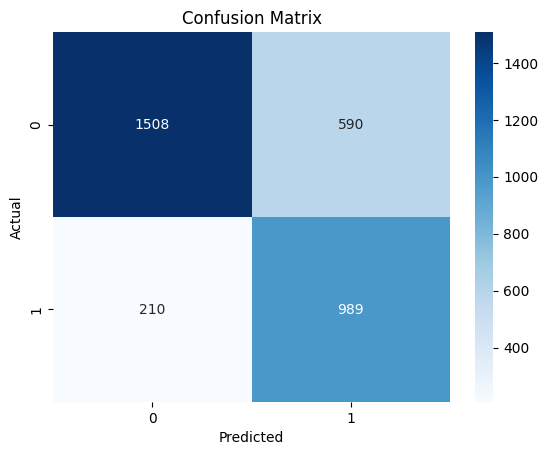

Classification Report:

              precision    recall  f1-score   support

           0     0.8778    0.7188    0.7904      2098
           1     0.6263    0.8249    0.7120      1199

    accuracy                         0.7574      3297
   macro avg     0.7521    0.7718    0.7512      3297
weighted avg     0.7863    0.7574    0.7619      3297



In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = log_reg.predict(X_test)

# 混淆矩陣
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# classification report（包含 precision, recall, f1-score）
print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

In [21]:
pd.set_option('display.max_row', None)

In [22]:
coef_df = pd.DataFrame(log_reg.coef_, columns=X.columns)
coef_df.T.sort_values(by=0, ascending=False).head(77)

,0
month_8,1.088163
month_11,0.647992
month_9,0.551165
sunHour,0.542979
month_12,0.468268
month_7,0.265440
month_10,0.086014
totalSnow,0.009221
year,-0.001591
avgtempF,-0.006095


In [23]:
log_reg.coef_

array([[-0.00609488,  0.00922107, -0.02593307, -0.26969065, -0.43966367,
         0.54297853, -0.00159086, -0.5240136 , -0.91722015, -0.59754993,
        -0.37368111, -0.45151369, -0.27830824,  0.2654397 ,  1.08816347,
         0.55116498,  0.08601395,  0.64799208,  0.46826796]])

- 這段程式碼是在對特徵進行標準化（`Standardization）`，讓每個特徵轉換成平均值為 0、標準差為 `1 的分佈，這對像是 Logistic Regression、SVM、KNN` 等模型尤其重要。

In [24]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

## KNN

Model saved in run 4e3035177dfb4f688bf5da9c0d495c3c
Train Accuracy: 0.9986997789624236
Test Accuracy: 0.8492569002123143


2025/05/02 19:05:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'knn-model' already exists. Creating a new version of this model...
Created version '3' of model 'knn-model'.


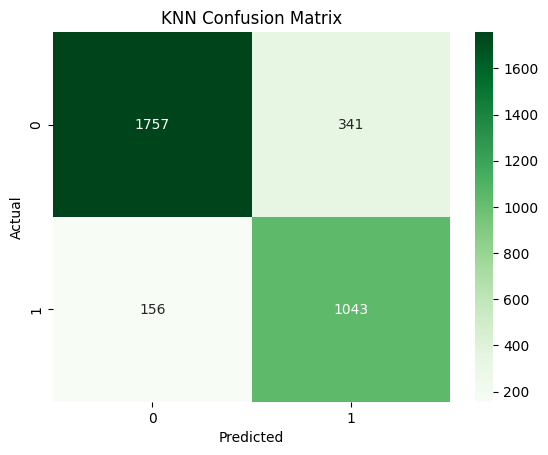

Classification Report:

              precision    recall  f1-score   support

           0     0.9185    0.8375    0.8761      2098
           1     0.7536    0.8699    0.8076      1199

    accuracy                         0.8493      3297
   macro avg     0.8360    0.8537    0.8418      3297
weighted avg     0.8585    0.8493    0.8512      3297



In [ ]:

#KNN 
# N=3
#Train Accuracy: 0.9986997789624236
#Test Accuracy: 0.8495602062481044
with mlflow.start_run(run_name='knn'):#mlflow
    mlflow.log_param("n_neighbors", 5)
    mlflow.log_param("weights", "distance")

    knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
    knn.fit(X_train_sc, y_train)
    
    run_id = mlflow.active_run().info.run_id#mlflow
    print(f"Model saved in run {run_id}")#mlflow

    # 預測
    y_pred_knn = knn.predict(X_test_sc)

    # Train / Test accuracy
    print("Train Accuracy:", knn.score(X_train_sc, y_train))
    print("Test Accuracy:", knn.score(X_test_sc, y_test))

    #mlflow
    mlflow.log_metric("Train score", knn.score(X_train_sc, y_train))#mlflow
    mlflow.log_metric("Test score", knn.score(X_test_sc, y_test))#mlflow
    mlflow.sklearn.log_model(     #mlflow.sklearn.log_model() #紀錄sklearn模型
        sk_model=knn, 
        artifact_path="knn-model",
        registered_model_name="knn-model",  #
    )


    # 混淆矩陣
    cm2 = confusion_matrix(y_test, y_pred_knn)
    sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("KNN Confusion Matrix")
    plt.show()

    # classification report
    print("Classification Report:\n")
    print(classification_report(y_test, y_pred_knn, digits=4))

## RF 隨機森林

Train Accuracy: 0.9668443635418021
Test Accuracy: 0.8707916287534122


2025/05/02 19:05:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'RandomForest-model'.
Created version '1' of model 'RandomForest-model'.


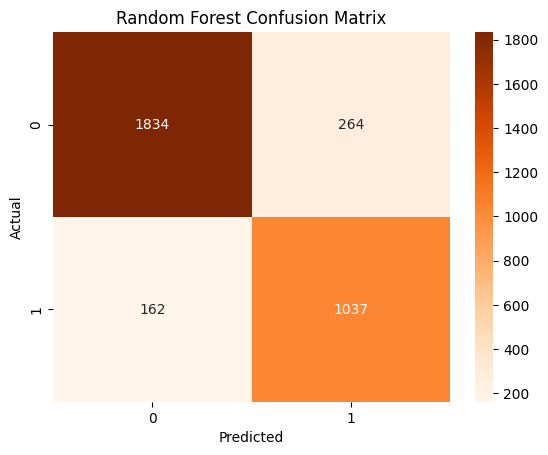

Classification Report:

              precision    recall  f1-score   support

           0     0.9188    0.8742    0.8959      2098
           1     0.7971    0.8649    0.8296      1199

    accuracy                         0.8708      3297
   macro avg     0.8580    0.8695    0.8628      3297
weighted avg     0.8746    0.8708    0.8718      3297



In [ ]:
#Random Forest 隨機森林

#Train Accuracy: 0.9837472370302951
#Test Accuracy: 0.8823172581134364
with mlflow.start_run(run_name='RandomForest'):#mlflow
    n_estimators = 150 #樹的數量
    max_depth = 15 #樹的深度
    
    mlflow.log_param("n_estimators", n_estimators) #mlflow
    mlflow.log_param("max_depth", max_depth) #mlflow
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight='balanced')
    rf.fit(X_train, y_train)

    # 預測
    y_pred_rf = rf.predict(X_test)

    # 準確率
    print("Train Accuracy:", rf.score(X_train, y_train))
    print("Test Accuracy:", rf.score(X_test, y_test))

    mlflow.log_metric("Train score", rf.score(X_train, y_train))#mlflow
    mlflow.log_metric("Test score", rf.score(X_test, y_test))#mlflow

    mlflow.sklearn.log_model(     #mlflow.sklearn.log_model() #紀錄sklearn模型
        sk_model=log_reg, 
        artifact_path="RandomForest-model",
        registered_model_name='RandomForest-model',  
    )   

    # 混淆矩陣
    cm3 = confusion_matrix(y_test, y_pred_rf)
    sns.heatmap(cm3, annot=True, fmt='d', cmap='Oranges', xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Random Forest Confusion Matrix")
    plt.show()

    # classification report
    print("Classification Report:\n")
    print(classification_report(y_test, y_pred_rf, digits=4))

In [27]:
rf.feature_importances_

array([0.19149289, 0.01691991, 0.20101253, 0.12372848, 0.10338974,
       0.21563326, 0.06335045, 0.00510869, 0.00443624, 0.00375368,
       0.00700569, 0.0066325 , 0.00538288, 0.02156181, 0.00814198,
       0.00786354, 0.00706465, 0.00361259, 0.00390849])

In [28]:
feature_df = pd.DataFrame(rf.feature_importances_, index=X.columns)
feature_df.sort_values(by=0, ascending=False)

,0
sunHour,0.215633
humid,0.201013
avgtempF,0.191493
wind,0.123728
precip,0.103390
year,0.063350
month_7,0.021562
totalSnow,0.016920
month_8,0.008142
month_9,0.007864


In [29]:
log_reg.predict(X_test)
knn.predict(X_test)
rf.predict(X_test)

C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


array([1, 0, 0, ..., 0, 0, 0])

In [30]:
pred_df = pd.DataFrame(columns=['log_reg', 'knn', 'rf'])
pred_df['log_reg'] = log_reg.predict(X_test)
pred_df['knn'] = knn.predict(X_test)
pred_df['rf'] = rf.predict(X_test)
pred_df['ensemble'] = (pred_df.sum(axis=1)/3).round(0)
pred_df.head()

C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


,log_reg,knn,rf,ensemble
0,1,0,1,1.0
1,0,0,0,0.0
2,0,0,0,0.0
3,1,0,1,1.0
4,0,0,0,0.0


In [31]:
metrics.accuracy_score(pred_df['ensemble'], y_test)

0.8089171974522293

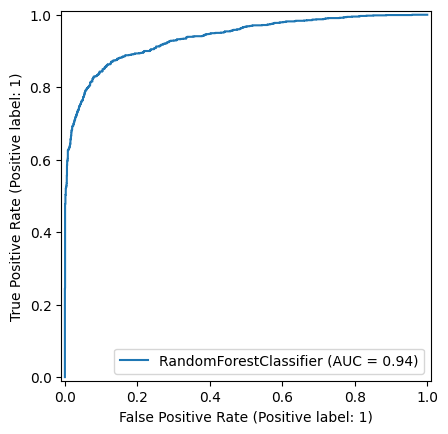

In [32]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(rf, X_test, y_test)

## DNN

In [ ]:
with mlflow.start_run(run_name='DNN'):#mlflow
    mlflow.tensorflow.autolog()#mlflow    

    n_input = X_train.shape[1]

    model = Sequential()
    model.add(BatchNormalization())
    model.add(Dense(256, input_shape=(n_input,), activation='relu'))
    model.add(Dropout(0.1))  # 增加 Dropout 率，避免過擬合
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.1))  # Dropout 率可根據需要進行調整
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))  # Dropout 率可根據需要進行調整
    model.add(Dense(1, activation='sigmoid'))


    # 模型optimizer 和 learning rate


    initial_lr = 0.001
    from tensorflow.keras.optimizers import schedules
    lr_schedule = schedules.ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True)
    from tensorflow.keras.optimizers import Adam
    optimizer = Adam(learning_rate=lr_schedule)

    mlflow.log_param("loss", 'bce') #mlflow
    model.compile(loss='bce', optimizer=optimizer, metrics=['acc', 'Recall', 'Precision'])

    # EarlyStopping: 根據 val_loss 停止訓練
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    # ModelCheckpoint: 儲存最佳模型
    from tensorflow.keras.callbacks import ModelCheckpoint
    checkpoint = ModelCheckpoint('./models_temp/DNN_best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128, verbose=1)

    model.evaluate(X_test, y_test)

C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025/05/02 19:05:12 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '40aba217ad75463ea1d2f86d1d9ce688', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2025/05/02 19:05:12 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: Sequential model 'sequential' has no defined input shape yet.
2025/05/02 19:05:12 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'pandas.core.frame.DataFrame'>. Datase

Epoch 1/100
50/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6266 - Recall: 0.5298 - acc: 0.7196 - loss: 0.5293

61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - Precision: 0.6298 - Recall: 0.5531 - acc: 0.7241 - loss: 0.5242 - val_Precision: 0.3637 - val_Recall: 1.0000 - val_acc: 0.3637 - val_loss: 3.6370
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6664 - Recall: 0.6734 - acc: 0.7598 - loss: 0.4811 - val_Precision: 0.3637 - val_Recall: 1.0000 - val_acc: 0.3637 - val_loss: 16.0516
Epoch 3/100
50/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6497 - Recall: 0.6788 - acc: 0.7565 - loss: 0.4788

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6518 - Recall: 0.6803 - acc: 0.7571 - loss: 0.4780 - val_Precision: 0.3868 - val_Recall: 0.9892 - val_acc: 0.4258 - val_loss: 1.5652
Epoch 4/100
51/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6642 - Recall: 0.7037 - acc: 0.7647 - loss: 0.4567

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6645 - Recall: 0.7002 - acc: 0.7644 - loss: 0.4598 - val_Precision: 0.4973 - val_Recall: 0.9199 - val_acc: 0.6327 - val_loss: 0.9144
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6680 - Recall: 0.7253 - acc: 0.7684 - loss: 0.4767 - val_Precision: 0.4169 - val_Recall: 0.9399 - val_acc: 0.5002 - val_loss: 1.0947
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6725 - Recall: 0.7372 - acc: 0.7726 - loss: 0.4663 - val_Precision: 0.4082 - val_Recall: 0.9516 - val_acc: 0.4807 - val_loss: 1.2521
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6695 - Recall: 0.6886 - acc: 0.7641 - loss: 0.4680

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6696 - Recall: 0.6886 - acc: 0.7641 - loss: 0.4679 - val_Precision: 0.6307 - val_Recall: 0.7306 - val_acc: 0.7464 - val_loss: 0.5721
Epoch 8/100
46/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6821 - Recall: 0.6644 - acc: 0.7655 - loss: 0.4577

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6820 - Recall: 0.6646 - acc: 0.7659 - loss: 0.4580 - val_Precision: 0.6961 - val_Recall: 0.6322 - val_acc: 0.7658 - val_loss: 0.4920
Epoch 9/100
49/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6922 - Recall: 0.6693 - acc: 0.7718 - loss: 0.4565

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6907 - Recall: 0.6730 - acc: 0.7721 - loss: 0.4568 - val_Precision: 0.6907 - val_Recall: 0.6464 - val_acc: 0.7662 - val_loss: 0.4702
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6945 - Recall: 0.6840 - acc: 0.7768 - loss: 0.4502 - val_Precision: 0.6618 - val_Recall: 0.7506 - val_acc: 0.7698 - val_loss: 0.4791
Epoch 11/100
53/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6724 - Recall: 0.7072 - acc: 0.7717 - loss: 0.4589

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6745 - Recall: 0.7070 - acc: 0.7725 - loss: 0.4585 - val_Precision: 0.6884 - val_Recall: 0.7148 - val_acc: 0.7786 - val_loss: 0.4563
Epoch 12/100
47/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6820 - Recall: 0.6720 - acc: 0.7736 - loss: 0.4503

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6839 - Recall: 0.6791 - acc: 0.7750 - loss: 0.4496 - val_Precision: 0.6791 - val_Recall: 0.7465 - val_acc: 0.7795 - val_loss: 0.4546
Epoch 13/100
49/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6999 - Recall: 0.6726 - acc: 0.7808 - loss: 0.4460

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7002 - Recall: 0.6776 - acc: 0.7814 - loss: 0.4457 - val_Precision: 0.7041 - val_Recall: 0.7164 - val_acc: 0.7874 - val_loss: 0.4530
Epoch 14/100
49/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6949 - Recall: 0.6825 - acc: 0.7808 - loss: 0.4454

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6958 - Recall: 0.6856 - acc: 0.7815 - loss: 0.4444 - val_Precision: 0.6831 - val_Recall: 0.7731 - val_acc: 0.7871 - val_loss: 0.4505
Epoch 15/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6956 - Recall: 0.7471 - acc: 0.7914 - loss: 0.4248 - val_Precision: 0.6686 - val_Recall: 0.7873 - val_acc: 0.7807 - val_loss: 0.4527
Epoch 16/100
50/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7181 - Recall: 0.7316 - acc: 0.7995 - loss: 0.4357

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7179 - Recall: 0.7302 - acc: 0.7990 - loss: 0.4360 - val_Precision: 0.6923 - val_Recall: 0.7431 - val_acc: 0.7865 - val_loss: 0.4460
Epoch 17/100
54/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7019 - Recall: 0.7241 - acc: 0.7937 - loss: 0.4267

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7031 - Recall: 0.7243 - acc: 0.7938 - loss: 0.4272 - val_Precision: 0.6836 - val_Recall: 0.7731 - val_acc: 0.7874 - val_loss: 0.4388
Epoch 18/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7143 - Recall: 0.7263 - acc: 0.7988 - loss: 0.4257 - val_Precision: 0.6808 - val_Recall: 0.7756 - val_acc: 0.7862 - val_loss: 0.4451
Epoch 19/100
47/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7045 - Recall: 0.7682 - acc: 0.8025 - loss: 0.4192

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7061 - Recall: 0.7623 - acc: 0.8015 - loss: 0.4201 - val_Precision: 0.7183 - val_Recall: 0.7189 - val_acc: 0.7953 - val_loss: 0.4336
Epoch 20/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7138 - Recall: 0.7004 - acc: 0.7867 - loss: 0.4377 - val_Precision: 0.6914 - val_Recall: 0.7923 - val_acc: 0.7959 - val_loss: 0.4381
Epoch 21/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6905 - Recall: 0.7740 - acc: 0.7941 - loss: 0.4264 - val_Precision: 0.6997 - val_Recall: 0.7423 - val_acc: 0.7904 - val_loss: 0.4390
Epoch 22/100
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6955 - Recall: 0.7465 - acc: 0.7950 - loss: 0.4215

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6968 - Recall: 0.7474 - acc: 0.7952 - loss: 0.4212 - val_Precision: 0.7247 - val_Recall: 0.7048 - val_acc: 0.7953 - val_loss: 0.4308
Epoch 23/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7309 - Recall: 0.7257 - acc: 0.8066 - loss: 0.4051 - val_Precision: 0.7114 - val_Recall: 0.7339 - val_acc: 0.7950 - val_loss: 0.4323
Epoch 24/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7353 - Recall: 0.7546 - acc: 0.8167 - loss: 0.3968 - val_Precision: 0.6979 - val_Recall: 0.7648 - val_acc: 0.7941 - val_loss: 0.4374
Epoch 25/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7249 - Recall: 0.7513 - acc: 0.8050 - loss: 0.4061 - val_Precision: 0.6803 - val_Recall: 0.7756 - val_acc: 0.7859 - val_loss: 0.4372
Epoch 26/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7223 - Recall: 0.7414 - acc: 0.8071 - loss: 0.4075 - val_Precision: 0.7156 - val_Recall: 0.7198 - val_acc: 0.7941 - val_loss: 0.4328
Epoch 27/100


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7312 - Recall: 0.7326 - acc: 0.8060 - loss: 0.3997 - val_Precision: 0.7467 - val_Recall: 0.7106 - val_acc: 0.8071 - val_loss: 0.4304
Epoch 28/100
50/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7308 - Recall: 0.7102 - acc: 0.8052 - loss: 0.3945

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7313 - Recall: 0.7150 - acc: 0.8057 - loss: 0.3955 - val_Precision: 0.7071 - val_Recall: 0.7531 - val_acc: 0.7968 - val_loss: 0.4280
Epoch 29/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7288 - Recall: 0.7523 - acc: 0.8115 - loss: 0.3890 - val_Precision: 0.6821 - val_Recall: 0.7873 - val_acc: 0.7892 - val_loss: 0.4320
Epoch 30/100
50/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7343 - Recall: 0.7666 - acc: 0.8106 - loss: 0.3889

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7343 - Recall: 0.7637 - acc: 0.8109 - loss: 0.3903 - val_Precision: 0.7270 - val_Recall: 0.7398 - val_acc: 0.8044 - val_loss: 0.4227
Epoch 31/100
47/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7254 - Recall: 0.7565 - acc: 0.8136 - loss: 0.3927

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7272 - Recall: 0.7563 - acc: 0.8132 - loss: 0.3934 - val_Precision: 0.7317 - val_Recall: 0.7573 - val_acc: 0.8107 - val_loss: 0.4160
Epoch 32/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7606 - Recall: 0.7525 - acc: 0.8242 - loss: 0.3764 - val_Precision: 0.7256 - val_Recall: 0.7565 - val_acc: 0.8074 - val_loss: 0.4197
Epoch 33/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7499 - Recall: 0.7518 - acc: 0.8235 - loss: 0.3787 - val_Precision: 0.7385 - val_Recall: 0.7231 - val_acc: 0.8062 - val_loss: 0.4184
Epoch 34/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7512 - Recall: 0.7415 - acc: 0.8151 - loss: 0.3899 - val_Precision: 0.7007 - val_Recall: 0.8007 - val_acc: 0.8032 - val_loss: 0.4197
Epoch 35/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7401 - Recall: 0.7750 - acc: 0.8216 - loss: 0.3845 - val_Precision: 0.7142 - val_Recall: 0.7773 - val_acc: 0.8059 - val_loss: 0.4183
Epoch 36/100


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7395 - Recall: 0.7789 - acc: 0.8234 - loss: 0.3816 - val_Precision: 0.7252 - val_Recall: 0.7681 - val_acc: 0.8098 - val_loss: 0.4141
Epoch 37/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7387 - Recall: 0.7766 - acc: 0.8208 - loss: 0.3835 - val_Precision: 0.7436 - val_Recall: 0.7064 - val_acc: 0.8047 - val_loss: 0.4189
Epoch 38/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7606 - Recall: 0.7434 - acc: 0.8240 - loss: 0.3863 - val_Precision: 0.7285 - val_Recall: 0.7364 - val_acc: 0.8044 - val_loss: 0.4169
Epoch 39/100
49/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7577 - Recall: 0.7778 - acc: 0.8302 - loss: 0.3672

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7582 - Recall: 0.7749 - acc: 0.8295 - loss: 0.3686 - val_Precision: 0.7516 - val_Recall: 0.7064 - val_acc: 0.8083 - val_loss: 0.4128
Epoch 40/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7662 - Recall: 0.7446 - acc: 0.8295 - loss: 0.3641 - val_Precision: 0.7224 - val_Recall: 0.7790 - val_acc: 0.8107 - val_loss: 0.4219
Epoch 41/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7603 - Recall: 0.7505 - acc: 0.8246 - loss: 0.3780 - val_Precision: 0.6928 - val_Recall: 0.7882 - val_acc: 0.7959 - val_loss: 0.4252
Epoch 42/100
48/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7633 - Recall: 0.8002 - acc: 0.8359 - loss: 0.3692

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7646 - Recall: 0.7947 - acc: 0.8357 - loss: 0.3685 - val_Precision: 0.7492 - val_Recall: 0.7448 - val_acc: 0.8165 - val_loss: 0.4126
Epoch 43/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7505 - Recall: 0.7750 - acc: 0.8257 - loss: 0.3714 - val_Precision: 0.7310 - val_Recall: 0.7456 - val_acc: 0.8077 - val_loss: 0.4160
Epoch 44/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7562 - Recall: 0.7268 - acc: 0.8195 - loss: 0.3708 - val_Precision: 0.7257 - val_Recall: 0.7523 - val_acc: 0.8065 - val_loss: 0.4141
Epoch 45/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7763 - Recall: 0.7543 - acc: 0.8324 - loss: 0.3553 - val_Precision: 0.7439 - val_Recall: 0.7314 - val_acc: 0.8107 - val_loss: 0.4189
Epoch 46/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7789 - Recall: 0.7680 - acc: 0.8358 - loss: 0.3473 - val_Precision: 0.7288 - val_Recall: 0.7823 - val_acc: 0.8150 - val_loss: 0.4130
Epoch 47/100


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7800 - Recall: 0.7890 - acc: 0.8409 - loss: 0.3517 - val_Precision: 0.7408 - val_Recall: 0.7556 - val_acc: 0.8150 - val_loss: 0.4113
Epoch 48/100
51/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7781 - Recall: 0.7763 - acc: 0.8378 - loss: 0.3638

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7769 - Recall: 0.7764 - acc: 0.8374 - loss: 0.3628 - val_Precision: 0.7469 - val_Recall: 0.7456 - val_acc: 0.8156 - val_loss: 0.4110
Epoch 49/100
49/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7880 - Recall: 0.7774 - acc: 0.8388 - loss: 0.3561

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7842 - Recall: 0.7758 - acc: 0.8378 - loss: 0.3565 - val_Precision: 0.7310 - val_Recall: 0.7615 - val_acc: 0.8113 - val_loss: 0.4090
Epoch 50/100
48/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7739 - Recall: 0.7769 - acc: 0.8390 - loss: 0.3477

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7747 - Recall: 0.7754 - acc: 0.8388 - loss: 0.3494 - val_Precision: 0.7289 - val_Recall: 0.7848 - val_acc: 0.8156 - val_loss: 0.4088
Epoch 51/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7499 - Recall: 0.8008 - acc: 0.8282 - loss: 0.3658 - val_Precision: 0.7263 - val_Recall: 0.7723 - val_acc: 0.8113 - val_loss: 0.4157
Epoch 52/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7622 - Recall: 0.7967 - acc: 0.8388 - loss: 0.3553 - val_Precision: 0.7444 - val_Recall: 0.7698 - val_acc: 0.8201 - val_loss: 0.4133
Epoch 53/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7688 - Recall: 0.7843 - acc: 0.8356 - loss: 0.3512 - val_Precision: 0.7456 - val_Recall: 0.7748 - val_acc: 0.8220 - val_loss: 0.4137
Epoch 54/100
53/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7712 - Recall: 0.7775 - acc: 0.8358 - loss: 0.3553

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7718 - Recall: 0.7784 - acc: 0.8364 - loss: 0.3547 - val_Precision: 0.7522 - val_Recall: 0.7673 - val_acc: 0.8235 - val_loss: 0.4076
Epoch 55/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - Precision: 0.7877 - Recall: 0.7837 - acc: 0.8481 - loss: 0.3389 - val_Precision: 0.7274 - val_Recall: 0.7990 - val_acc: 0.8180 - val_loss: 0.4165
Epoch 56/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7621 - Recall: 0.8118 - acc: 0.8387 - loss: 0.3449 - val_Precision: 0.7448 - val_Recall: 0.7448 - val_acc: 0.8144 - val_loss: 0.4127
Epoch 57/100
44/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.7939 - Recall: 0.8061 - acc: 0.8544 - loss: 0.3267

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7912 - Recall: 0.8039 - acc: 0.8527 - loss: 0.3294 - val_Precision: 0.7540 - val_Recall: 0.7798 - val_acc: 0.8274 - val_loss: 0.4038
Epoch 58/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.8020 - Recall: 0.8013 - acc: 0.8565 - loss: 0.3197 - val_Precision: 0.7471 - val_Recall: 0.7615 - val_acc: 0.8195 - val_loss: 0.4079
Epoch 59/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7848 - Recall: 0.7905 - acc: 0.8454 - loss: 0.3435 - val_Precision: 0.7458 - val_Recall: 0.7490 - val_acc: 0.8159 - val_loss: 0.4083
Epoch 60/100
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.7958 - Recall: 0.7914 - acc: 0.8517 - loss: 0.3364

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7954 - Recall: 0.7912 - acc: 0.8515 - loss: 0.3364 - val_Precision: 0.7675 - val_Recall: 0.7598 - val_acc: 0.8289 - val_loss: 0.4024
Epoch 61/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.8043 - Recall: 0.7832 - acc: 0.8561 - loss: 0.3225 - val_Precision: 0.7482 - val_Recall: 0.7882 - val_acc: 0.8265 - val_loss: 0.4062
Epoch 62/100
50/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7913 - Recall: 0.7913 - acc: 0.8453 - loss: 0.3347

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7906 - Recall: 0.7901 - acc: 0.8455 - loss: 0.3349 - val_Precision: 0.7574 - val_Recall: 0.7681 - val_acc: 0.8262 - val_loss: 0.3982
Epoch 63/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7951 - Recall: 0.7935 - acc: 0.8488 - loss: 0.3316 - val_Precision: 0.7320 - val_Recall: 0.7882 - val_acc: 0.8180 - val_loss: 0.4116
Epoch 64/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7960 - Recall: 0.7842 - acc: 0.8510 - loss: 0.3359 - val_Precision: 0.7518 - val_Recall: 0.7681 - val_acc: 0.8235 - val_loss: 0.4000
Epoch 65/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7971 - Recall: 0.7730 - acc: 0.8522 - loss: 0.3186 - val_Precision: 0.7539 - val_Recall: 0.7715 - val_acc: 0.8253 - val_loss: 0.4029
Epoch 66/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.8067 - Recall: 0.8048 - acc: 0.8583 - loss: 0.3187 - val_Precision: 0.7630 - val_Recall: 0.7490 - val_acc: 0.8241 - val_loss: 0.4061
Epoch 67/100


2025/05/02 19:05:50 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2025/05/02 19:05:50 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/05/02 19:05:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - Precision: 0.7622 - Recall: 0.8164 - acc: 0.8430 - loss: 0.4112


[0.4092269241809845,
 0.8374279737472534,
 0.8156797289848328,
 0.7563804984092712]

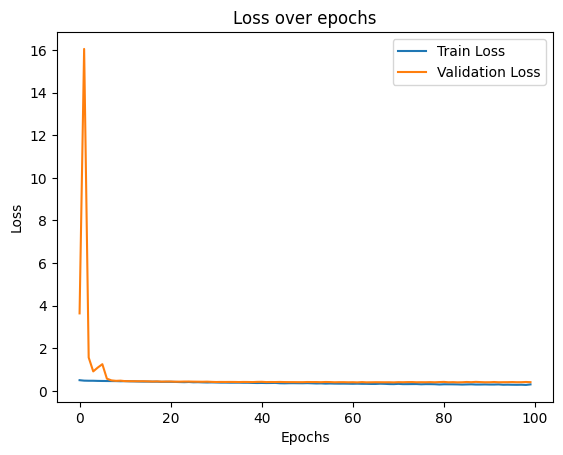

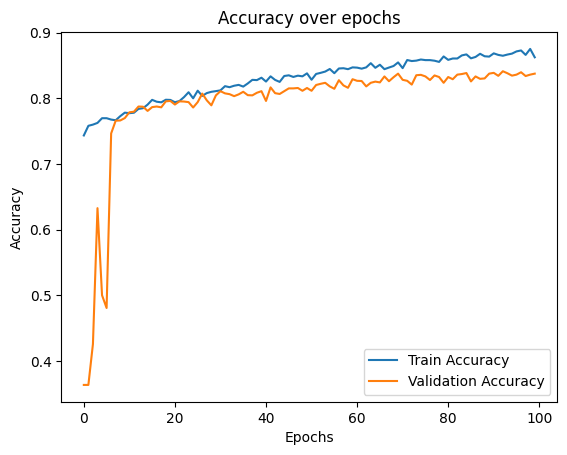

In [34]:
import matplotlib.pyplot as plt

# Loss 曲線
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

# Accuracy 曲線
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


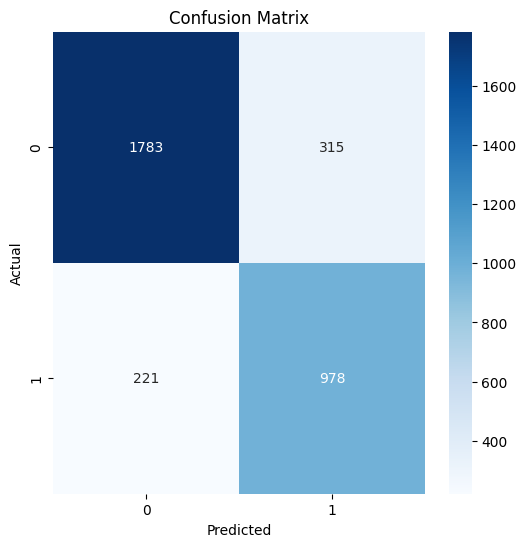

Classification Report:

              precision    recall  f1-score   support

           0     0.8897    0.8499    0.8693      2098
           1     0.7564    0.8157    0.7849      1199

    accuracy                         0.8374      3297
   macro avg     0.8231    0.8328    0.8271      3297
weighted avg     0.8412    0.8374    0.8386      3297



In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 預測結果
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype(int)  # 轉換為二分類結果

# 計算混淆矩陣
cm_f = confusion_matrix(y_test, y_pred_class)

# 繪製混淆矩陣
plt.figure(figsize=(6, 6))
sns.heatmap(cm_f, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_class, digits=4))

In [36]:
#history_df = pd.DataFrame(history.history)
#history_df.sort_values(by='acc', ascending=False)

## Attention Mechanism

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, MultiHeadAttention, Flatten, GlobalAveragePooling1D, Reshape
from tensorflow.keras.models import Model

#
with mlflow.start_run(run_name='AttentionMechanisim'):#mlflow
    mlflow.tensorflow.autolog()#mlflow    
    n_input = X_train.shape[1]
    # Model
    # 定義模型
    input_layer = Input(shape=(n_input,))
    x = BatchNormalization()(input_layer)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    # Reshape 輸入，以便進行注意力機制（將它變成三維張量）
    x = Reshape((1, 128))(x)  # 假設每個樣本有 128 個特徵，這樣就會有 1 個時間步
    # 添加多頭注意力層
    x_attention = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)  # query, key 和 value 都是 x
    x_attention = Dropout(0.1)(x_attention)
    # 將注意力層的輸出展平
    x_flattened = Flatten()(x_attention)
    # 經過展平後的處理
    x = Dense(128, activation='relu')(x_flattened)
    x = Dropout(0.1)(x)
    output = Dense(1, activation='sigmoid')(x)


    # Model
    model = Model(inputs=input_layer, outputs=output)
    model.summary()
    # 模型optimizer 和 learning rate
    initial_lr = 0.001
    from tensorflow.keras.optimizers import schedules
    lr_schedule = schedules.ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True)
    from tensorflow.keras.optimizers import Adam
    optimizer = Adam(learning_rate=lr_schedule)

    model.compile(loss='bce', optimizer=optimizer, metrics=['acc', 'Recall', 'Precision'])
    # EarlyStopping: 根據 val_loss 停止訓練
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    # ModelCheckpoint: 儲存最佳模型
    checkpoint = ModelCheckpoint('./models_temp/attention_best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=128, verbose=1, callbacks=[early_stop, checkpoint])

    # 評估模型
    model.evaluate(X_test, y_test)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19)        │         76 │ input_layer_1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │      2,560 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 128)    │          0 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 128)    │     66,048 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 1, 128)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 128)       │          0 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     16,512 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │        129 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 85,325 (333.30 KB)

 Trainable params: 85,287 (333.15 KB)

 Non-trainable params: 38 (152.00 B)

2025/05/02 19:05:56 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '73d1695fa1f94240b2e65d6311422f28', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2025/05/02 19:05:56 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'pandas.core.frame.DataFrame'>. Dataset logging skipped.
2025/05/02 19:05:56 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'


Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.5753 - Recall: 0.4996 - acc: 0.6935 - loss: 0.5476
Epoch 1: val_loss improved from inf to 23.58389, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - Precision: 0.5762 - Recall: 0.5018 - acc: 0.6942 - loss: 0.5470 - val_Precision: 0.3637 - val_Recall: 1.0000 - val_acc: 0.3637 - val_loss: 23.5839
Epoch 2/100
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6438 - Recall: 0.6936 - acc: 0.7551 - loss: 0.4770
Epoch 2: val_loss improved from 23.58389 to 13.15800, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.6439 - Recall: 0.6928 - acc: 0.7549 - loss: 0.4774 - val_Precision: 0.3637 - val_Recall: 1.0000 - val_acc: 0.3637 - val_loss: 13.1580
Epoch 3/100
54/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6734 - Recall: 0.6590 - acc: 0.7596 - loss: 0.4813
Epoch 3: val_loss improved from 13.15800 to 7.62061, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.6720 - Recall: 0.6602 - acc: 0.7594 - loss: 0.4812 - val_Precision: 0.3637 - val_Recall: 1.0000 - val_acc: 0.3637 - val_loss: 7.6206
Epoch 4/100
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6631 - Recall: 0.7042 - acc: 0.7624 - loss: 0.4744
Epoch 4: val_loss improved from 7.62061 to 0.49745, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.6631 - Recall: 0.7036 - acc: 0.7623 - loss: 0.4744 - val_Precision: 0.6962 - val_Recall: 0.6422 - val_acc: 0.7680 - val_loss: 0.4974
Epoch 5/100
58/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6517 - Recall: 0.6967 - acc: 0.7555 - loss: 0.4781
Epoch 5: val_loss did not improve from 0.49745
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.6521 - Recall: 0.6960 - acc: 0.7556 - loss: 0.4780 - val_Precision: 0.3720 - val_Recall: 1.0000 - val_acc: 0.3861 - val_loss: 2.2394
Epoch 6/100
54/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6637 - Recall: 0.6706 - acc: 0.7605 - loss: 0.4756
Epoch 6: val_loss did not improve from 0.49745
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - Precision: 0.6636 - Recall: 0.6701 - acc: 0.7601 - loss: 0.4754 - val_Precision: 0.3910 - val_Recall: 0.9883 - val_acc: 0.4359 - val_loss: 1.4356
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6768 - Recall: 0.6851 - acc: 0.7656 - loss: 

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.6766 - Recall: 0.6744 - acc: 0.7705 - loss: 0.4620 - val_Precision: 0.6517 - val_Recall: 0.7506 - val_acc: 0.7634 - val_loss: 0.4900
Epoch 10/100
57/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6578 - Recall: 0.7502 - acc: 0.7696 - loss: 0.4618
Epoch 10: val_loss improved from 0.48999 to 0.46861, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.6581 - Recall: 0.7472 - acc: 0.7692 - loss: 0.4622 - val_Precision: 0.6872 - val_Recall: 0.6797 - val_acc: 0.7710 - val_loss: 0.4686
Epoch 11/100
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6857 - Recall: 0.6709 - acc: 0.7728 - loss: 0.4588
Epoch 11: val_loss did not improve from 0.46861
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6858 - Recall: 0.6710 - acc: 0.7728 - loss: 0.4590 - val_Precision: 0.6393 - val_Recall: 0.7982 - val_acc: 0.7628 - val_loss: 0.4823
Epoch 12/100
55/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6636 - Recall: 0.6947 - acc: 0.7636 - loss: 0.4691
Epoch 12: val_loss improved from 0.46861 to 0.46081, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.6651 - Recall: 0.6941 - acc: 0.7642 - loss: 0.4688 - val_Precision: 0.6884 - val_Recall: 0.7314 - val_acc: 0.7819 - val_loss: 0.4608
Epoch 13/100
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6644 - Recall: 0.7025 - acc: 0.7654 - loss: 0.4687
Epoch 13: val_loss improved from 0.46081 to 0.45857, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.6656 - Recall: 0.7012 - acc: 0.7656 - loss: 0.4680 - val_Precision: 0.6963 - val_Recall: 0.6997 - val_acc: 0.7798 - val_loss: 0.4586
Epoch 14/100
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6753 - Recall: 0.7016 - acc: 0.7742 - loss: 0.4614
Epoch 14: val_loss improved from 0.45857 to 0.45700, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.6754 - Recall: 0.7017 - acc: 0.7741 - loss: 0.4615 - val_Precision: 0.6907 - val_Recall: 0.7039 - val_acc: 0.7777 - val_loss: 0.4570
Epoch 15/100
51/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6705 - Recall: 0.6814 - acc: 0.7665 - loss: 0.4721
Epoch 15: val_loss improved from 0.45700 to 0.45294, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.6732 - Recall: 0.6838 - acc: 0.7682 - loss: 0.4696 - val_Precision: 0.6889 - val_Recall: 0.7481 - val_acc: 0.7856 - val_loss: 0.4529
Epoch 16/100
54/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6854 - Recall: 0.7295 - acc: 0.7813 - loss: 0.4514
Epoch 16: val_loss did not improve from 0.45294
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6847 - Recall: 0.7256 - acc: 0.7801 - loss: 0.4524 - val_Precision: 0.7185 - val_Recall: 0.6555 - val_acc: 0.7813 - val_loss: 0.4581
Epoch 17/100
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7117 - Recall: 0.6754 - acc: 0.7826 - loss: 0.4525
Epoch 17: val_loss improved from 0.45294 to 0.45243, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.7087 - Recall: 0.6761 - acc: 0.7814 - loss: 0.4531 - val_Precision: 0.6934 - val_Recall: 0.7148 - val_acc: 0.7813 - val_loss: 0.4524
Epoch 18/100
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6891 - Recall: 0.6866 - acc: 0.7752 - loss: 0.4535
Epoch 18: val_loss did not improve from 0.45243
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6890 - Recall: 0.6870 - acc: 0.7752 - loss: 0.4534 - val_Precision: 0.6999 - val_Recall: 0.6906 - val_acc: 0.7798 - val_loss: 0.4574
Epoch 19/100
53/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7108 - Recall: 0.6781 - acc: 0.7829 - loss: 0.4497
Epoch 19: val_loss improved from 0.45243 to 0.44858, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.7087 - Recall: 0.6799 - acc: 0.7823 - loss: 0.4498 - val_Precision: 0.7074 - val_Recall: 0.6997 - val_acc: 0.7856 - val_loss: 0.4486
Epoch 20/100
56/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6971 - Recall: 0.7269 - acc: 0.7900 - loss: 0.4450
Epoch 20: val_loss did not improve from 0.44858
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6968 - Recall: 0.7255 - acc: 0.7893 - loss: 0.4455 - val_Precision: 0.6936 - val_Recall: 0.7098 - val_acc: 0.7804 - val_loss: 0.4496
Epoch 21/100
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6763 - Recall: 0.7116 - acc: 0.7758 - loss: 0.4451
Epoch 21: val_loss did not improve from 0.44858
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6783 - Recall: 0.7117 - acc: 0.7764 - loss: 0.4458 - val_Precision: 0.6929 - val_Recall: 0.7039 - val_acc: 0.7789 - val_loss: 0.4544
Epoch 22/100
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6945 - Recall: 0.6889 - acc: 0.7832 - lo

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.6946 - Recall: 0.6925 - acc: 0.7832 - loss: 0.4413 - val_Precision: 0.6996 - val_Recall: 0.7264 - val_acc: 0.7871 - val_loss: 0.4481
Epoch 23/100
53/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7045 - Recall: 0.7200 - acc: 0.7889 - loss: 0.4398
Epoch 23: val_loss did not improve from 0.44815
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.7036 - Recall: 0.7173 - acc: 0.7880 - loss: 0.4409 - val_Precision: 0.6904 - val_Recall: 0.7440 - val_acc: 0.7856 - val_loss: 0.4510
Epoch 24/100
50/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6836 - Recall: 0.7521 - acc: 0.7852 - loss: 0.4433
Epoch 24: val_loss did not improve from 0.44815
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6858 - Recall: 0.7468 - acc: 0.7851 - loss: 0.4440 - val_Precision: 0.7013 - val_Recall: 0.7031 - val_acc: 0.7831 - val_loss: 0.4627
Epoch 25/100
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7143 - Recall: 0.7101 - acc: 0.7903 - lo

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.7139 - Recall: 0.7098 - acc: 0.7901 - loss: 0.4491 - val_Precision: 0.7033 - val_Recall: 0.7256 - val_acc: 0.7889 - val_loss: 0.4470
Epoch 26/100
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7106 - Recall: 0.7055 - acc: 0.7892 - loss: 0.4414
Epoch 26: val_loss improved from 0.44704 to 0.44254, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.7104 - Recall: 0.7055 - acc: 0.7891 - loss: 0.4414 - val_Precision: 0.7150 - val_Recall: 0.6947 - val_acc: 0.7883 - val_loss: 0.4425
Epoch 27/100
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7087 - Recall: 0.6604 - acc: 0.7799 - loss: 0.4442
Epoch 27: val_loss did not improve from 0.44254
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.7087 - Recall: 0.6615 - acc: 0.7801 - loss: 0.4441 - val_Precision: 0.7190 - val_Recall: 0.7064 - val_acc: 0.7928 - val_loss: 0.4444
Epoch 28/100
57/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7060 - Recall: 0.6978 - acc: 0.7835 - loss: 0.4439
Epoch 28: val_loss did not improve from 0.44254
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7054 - Recall: 0.6987 - acc: 0.7836 - loss: 0.4440 - val_Precision: 0.6989 - val_Recall: 0.7473 - val_acc: 0.7910 - val_loss: 0.4435
Epoch 29/100
58/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7029 - Recall: 0.6919 - acc: 0.7881 - lo

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.7121 - Recall: 0.7264 - acc: 0.7919 - loss: 0.4335 - val_Precision: 0.6935 - val_Recall: 0.7339 - val_acc: 0.7853 - val_loss: 0.4421
Epoch 33/100
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6962 - Recall: 0.7326 - acc: 0.7911 - loss: 0.4323
Epoch 33: val_loss improved from 0.44209 to 0.44167, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.6968 - Recall: 0.7309 - acc: 0.7905 - loss: 0.4337 - val_Precision: 0.6970 - val_Recall: 0.7598 - val_acc: 0.7925 - val_loss: 0.4417
Epoch 34/100
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7115 - Recall: 0.7070 - acc: 0.7888 - loss: 0.4398
Epoch 34: val_loss did not improve from 0.44167
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7117 - Recall: 0.7074 - acc: 0.7890 - loss: 0.4395 - val_Precision: 0.7055 - val_Recall: 0.7273 - val_acc: 0.7904 - val_loss: 0.4465
Epoch 35/100
55/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7102 - Recall: 0.7099 - acc: 0.7925 - loss: 0.4433
Epoch 35: val_loss improved from 0.44167 to 0.44108, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.7101 - Recall: 0.7105 - acc: 0.7925 - loss: 0.4428 - val_Precision: 0.6923 - val_Recall: 0.7731 - val_acc: 0.7925 - val_loss: 0.4411
Epoch 36/100
53/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7150 - Recall: 0.7441 - acc: 0.7960 - loss: 0.4301
Epoch 36: val_loss improved from 0.44108 to 0.43515, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.7141 - Recall: 0.7418 - acc: 0.7958 - loss: 0.4308 - val_Precision: 0.7048 - val_Recall: 0.7548 - val_acc: 0.7959 - val_loss: 0.4351
Epoch 37/100
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7092 - Recall: 0.6750 - acc: 0.7837 - loss: 0.4399
Epoch 37: val_loss did not improve from 0.43515
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7104 - Recall: 0.6801 - acc: 0.7852 - loss: 0.4384 - val_Precision: 0.7074 - val_Recall: 0.7339 - val_acc: 0.7928 - val_loss: 0.4418
Epoch 38/100
55/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7016 - Recall: 0.6889 - acc: 0.7875 - loss: 0.4365
Epoch 38: val_loss did not improve from 0.43515
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.7033 - Recall: 0.6911 - acc: 0.7882 - loss: 0.4359 - val_Precision: 0.6966 - val_Recall: 0.7256 - val_acc: 0.7853 - val_loss: 0.4421
Epoch 39/100
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6986 - Recall: 0.7212 - acc: 0.7890 - lo

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.7129 - Recall: 0.7493 - acc: 0.7941 - loss: 0.4240 - val_Precision: 0.7241 - val_Recall: 0.7223 - val_acc: 0.7989 - val_loss: 0.4340
Epoch 42/100
54/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7100 - Recall: 0.7260 - acc: 0.7924 - loss: 0.4440
Epoch 42: val_loss did not improve from 0.43397
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7103 - Recall: 0.7269 - acc: 0.7929 - loss: 0.4421 - val_Precision: 0.7296 - val_Recall: 0.6931 - val_acc: 0.7950 - val_loss: 0.4412
Epoch 43/100
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7374 - Recall: 0.7279 - acc: 0.8005 - loss: 0.4305
Epoch 43: val_loss did not improve from 0.43397
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7339 - Recall: 0.7262 - acc: 0.7995 - loss: 0.4299 - val_Precision: 0.7138 - val_Recall: 0.7198 - val_acc: 0.7931 - val_loss: 0.4372
Epoch 44/100
55/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7218 - Recall: 0.7025 - acc: 0.7978 - lo

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.7216 - Recall: 0.7043 - acc: 0.7978 - loss: 0.4259 - val_Precision: 0.7113 - val_Recall: 0.7314 - val_acc: 0.7944 - val_loss: 0.4308
Epoch 45/100
54/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7134 - Recall: 0.6940 - acc: 0.7948 - loss: 0.4232
Epoch 45: val_loss did not improve from 0.43077
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.7143 - Recall: 0.6971 - acc: 0.7952 - loss: 0.4239 - val_Precision: 0.6892 - val_Recall: 0.7731 - val_acc: 0.7907 - val_loss: 0.4348
Epoch 46/100
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7172 - Recall: 0.7492 - acc: 0.8040 - loss: 0.4251
Epoch 46: val_loss did not improve from 0.43077
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7174 - Recall: 0.7487 - acc: 0.8039 - loss: 0.4250 - val_Precision: 0.7168 - val_Recall: 0.7556 - val_acc: 0.8025 - val_loss: 0.4338
Epoch 47/100
54/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6979 - Recall: 0.7425 - acc: 0.7948 - lo

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.6995 - Recall: 0.7418 - acc: 0.7950 - loss: 0.4328 - val_Precision: 0.7337 - val_Recall: 0.7306 - val_acc: 0.8056 - val_loss: 0.4298
Epoch 48/100
54/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7106 - Recall: 0.7069 - acc: 0.7900 - loss: 0.4220
Epoch 48: val_loss did not improve from 0.42984
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7115 - Recall: 0.7085 - acc: 0.7909 - loss: 0.4220 - val_Precision: 0.7163 - val_Recall: 0.7456 - val_acc: 0.8001 - val_loss: 0.4322
Epoch 49/100
53/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7068 - Recall: 0.7034 - acc: 0.7914 - loss: 0.4240
Epoch 49: val_loss did not improve from 0.42984
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7086 - Recall: 0.7055 - acc: 0.7924 - loss: 0.4239 - val_Precision: 0.6987 - val_Recall: 0.7640 - val_acc: 0.7944 - val_loss: 0.4344
Epoch 50/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7261 - Recall: 0.7528 - acc: 0.8112 - lo

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.7206 - Recall: 0.7441 - acc: 0.8024 - loss: 0.4221 - val_Precision: 0.7241 - val_Recall: 0.7289 - val_acc: 0.8004 - val_loss: 0.4282
Epoch 54/100
58/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7234 - Recall: 0.7426 - acc: 0.8061 - loss: 0.4152
Epoch 54: val_loss did not improve from 0.42816
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.7237 - Recall: 0.7423 - acc: 0.8060 - loss: 0.4154 - val_Precision: 0.7296 - val_Recall: 0.7248 - val_acc: 0.8022 - val_loss: 0.4325
Epoch 55/100
53/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7233 - Recall: 0.7193 - acc: 0.7980 - loss: 0.4166
Epoch 55: val_loss did not improve from 0.42816
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7234 - Recall: 0.7199 - acc: 0.7985 - loss: 0.4167 - val_Precision: 0.6903 - val_Recall: 0.7807 - val_acc: 0.7928 - val_loss: 0.4338
Epoch 56/100
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7101 - Recall: 0.7473 - acc: 0.8028 - lo

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.7105 - Recall: 0.7468 - acc: 0.8027 - loss: 0.4205 - val_Precision: 0.7088 - val_Recall: 0.7815 - val_acc: 0.8038 - val_loss: 0.4271
Epoch 57/100
58/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7137 - Recall: 0.7340 - acc: 0.7990 - loss: 0.4190
Epoch 57: val_loss did not improve from 0.42707
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.7141 - Recall: 0.7335 - acc: 0.7991 - loss: 0.4191 - val_Precision: 0.7348 - val_Recall: 0.7048 - val_acc: 0.8001 - val_loss: 0.4410
Epoch 58/100
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7462 - Recall: 0.6707 - acc: 0.8029 - loss: 0.4208
Epoch 58: val_loss did not improve from 0.42707
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7445 - Recall: 0.6782 - acc: 0.8032 - loss: 0.4211 - val_Precision: 0.7006 - val_Recall: 0.7690 - val_acc: 0.7965 - val_loss: 0.4304
Epoch 59/100
54/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7307 - Recall: 0.7459 - acc: 0.8084 - lo

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.7307 - Recall: 0.7451 - acc: 0.8083 - loss: 0.4118 - val_Precision: 0.7098 - val_Recall: 0.7648 - val_acc: 0.8007 - val_loss: 0.4262
Epoch 60/100
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7323 - Recall: 0.7418 - acc: 0.8105 - loss: 0.4132
Epoch 60: val_loss improved from 0.42619 to 0.42567, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.7324 - Recall: 0.7402 - acc: 0.8101 - loss: 0.4140 - val_Precision: 0.7273 - val_Recall: 0.7473 - val_acc: 0.8062 - val_loss: 0.4257
Epoch 61/100
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7227 - Recall: 0.6890 - acc: 0.7938 - loss: 0.4265
Epoch 61: val_loss did not improve from 0.42567
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7235 - Recall: 0.6937 - acc: 0.7950 - loss: 0.4250 - val_Precision: 0.7186 - val_Recall: 0.7498 - val_acc: 0.8022 - val_loss: 0.4288
Epoch 62/100
54/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7195 - Recall: 0.7381 - acc: 0.8009 - loss: 0.4128
Epoch 62: val_loss improved from 0.42567 to 0.42451, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.7202 - Recall: 0.7375 - acc: 0.8013 - loss: 0.4130 - val_Precision: 0.7192 - val_Recall: 0.7498 - val_acc: 0.8025 - val_loss: 0.4245
Epoch 63/100
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7439 - Recall: 0.7341 - acc: 0.8105 - loss: 0.4112
Epoch 63: val_loss did not improve from 0.42451
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7427 - Recall: 0.7338 - acc: 0.8103 - loss: 0.4114 - val_Precision: 0.7288 - val_Recall: 0.7373 - val_acc: 0.8047 - val_loss: 0.4294
Epoch 64/100
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7248 - Recall: 0.7404 - acc: 0.8060 - loss: 0.4068
Epoch 64: val_loss did not improve from 0.42451
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7250 - Recall: 0.7399 - acc: 0.8059 - loss: 0.4070 - val_Precision: 0.6888 - val_Recall: 0.7773 - val_acc: 0.7913 - val_loss: 0.4386
Epoch 65/100
53/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7157 - Recall: 0.6900 - acc: 0.7929 - lo

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - Precision: 0.7471 - Recall: 0.7130 - acc: 0.8064 - loss: 0.4090 - val_Precision: 0.7362 - val_Recall: 0.7331 - val_acc: 0.8074 - val_loss: 0.4244
Epoch 67/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7298 - Recall: 0.7256 - acc: 0.8035 - loss: 0.4105
Epoch 67: val_loss did not improve from 0.42439
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7297 - Recall: 0.7257 - acc: 0.8035 - loss: 0.4104 - val_Precision: 0.7396 - val_Recall: 0.7273 - val_acc: 0.8077 - val_loss: 0.4281
Epoch 68/100
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7459 - Recall: 0.7313 - acc: 0.8124 - loss: 0.4050
Epoch 68: val_loss improved from 0.42439 to 0.42245, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - Precision: 0.7447 - Recall: 0.7307 - acc: 0.8117 - loss: 0.4055 - val_Precision: 0.7529 - val_Recall: 0.7014 - val_acc: 0.8077 - val_loss: 0.4225
Epoch 69/100
51/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7748 - Recall: 0.7427 - acc: 0.8262 - loss: 0.3949
Epoch 69: val_loss improved from 0.42245 to 0.42239, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.7696 - Recall: 0.7403 - acc: 0.8237 - loss: 0.3973 - val_Precision: 0.7365 - val_Recall: 0.6947 - val_acc: 0.7986 - val_loss: 0.4224
Epoch 70/100
54/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7317 - Recall: 0.7192 - acc: 0.8077 - loss: 0.4038
Epoch 70: val_loss improved from 0.42239 to 0.42199, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.7321 - Recall: 0.7207 - acc: 0.8077 - loss: 0.4040 - val_Precision: 0.7322 - val_Recall: 0.7273 - val_acc: 0.8041 - val_loss: 0.4220
Epoch 71/100
56/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7513 - Recall: 0.7300 - acc: 0.8158 - loss: 0.3957
Epoch 71: val_loss improved from 0.42199 to 0.42096, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.7506 - Recall: 0.7295 - acc: 0.8153 - loss: 0.3970 - val_Precision: 0.7602 - val_Recall: 0.7114 - val_acc: 0.8135 - val_loss: 0.4210
Epoch 72/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7507 - Recall: 0.7433 - acc: 0.8208 - loss: 0.4001
Epoch 72: val_loss improved from 0.42096 to 0.42062, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.7505 - Recall: 0.7431 - acc: 0.8206 - loss: 0.4002 - val_Precision: 0.7536 - val_Recall: 0.6914 - val_acc: 0.8056 - val_loss: 0.4206
Epoch 73/100
54/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7482 - Recall: 0.7447 - acc: 0.8149 - loss: 0.4061
Epoch 73: val_loss did not improve from 0.42062
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7474 - Recall: 0.7442 - acc: 0.8148 - loss: 0.4058 - val_Precision: 0.7210 - val_Recall: 0.7306 - val_acc: 0.7992 - val_loss: 0.4270
Epoch 74/100
50/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7365 - Recall: 0.7452 - acc: 0.8097 - loss: 0.4037
Epoch 74: val_loss did not improve from 0.42062
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7358 - Recall: 0.7418 - acc: 0.8089 - loss: 0.4042 - val_Precision: 0.7258 - val_Recall: 0.7064 - val_acc: 0.7962 - val_loss: 0.4234
Epoch 75/100
54/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7482 - Recall: 0.7331 - acc: 0.8178 - lo

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.7618 - Recall: 0.7196 - acc: 0.8178 - loss: 0.3962 - val_Precision: 0.7262 - val_Recall: 0.7631 - val_acc: 0.8092 - val_loss: 0.4173
Epoch 80/100
55/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7570 - Recall: 0.7380 - acc: 0.8190 - loss: 0.3907
Epoch 80: val_loss improved from 0.41731 to 0.41731, saving model to ./models_temp/attention_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.7553 - Recall: 0.7354 - acc: 0.8177 - loss: 0.3916 - val_Precision: 0.7391 - val_Recall: 0.7206 - val_acc: 0.8059 - val_loss: 0.4173
Epoch 81/100
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7480 - Recall: 0.7303 - acc: 0.8169 - loss: 0.3907
Epoch 81: val_loss did not improve from 0.41731
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7478 - Recall: 0.7302 - acc: 0.8166 - loss: 0.3911 - val_Precision: 0.7514 - val_Recall: 0.6731 - val_acc: 0.8001 - val_loss: 0.4210
Epoch 82/100
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7312 - Recall: 0.6726 - acc: 0.7949 - loss: 0.4100
Epoch 82: val_loss did not improve from 0.41731
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7334 - Recall: 0.6775 - acc: 0.7966 - loss: 0.4095 - val_Precision: 0.7211 - val_Recall: 0.7656 - val_acc: 0.8071 - val_loss: 0.4214
Epoch 83/100
53/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7382 - Recall: 0.7515 - acc: 0.8129 - lo

2025/05/02 19:06:43 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2025/05/02 19:06:43 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/05/02 19:06:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Precision: 0.7392 - Recall: 0.7204 - acc: 0.8088 - loss: 0.4185


[0.4173050820827484,
 0.8058841228485107,
 0.7206004858016968,
 0.7390932440757751]

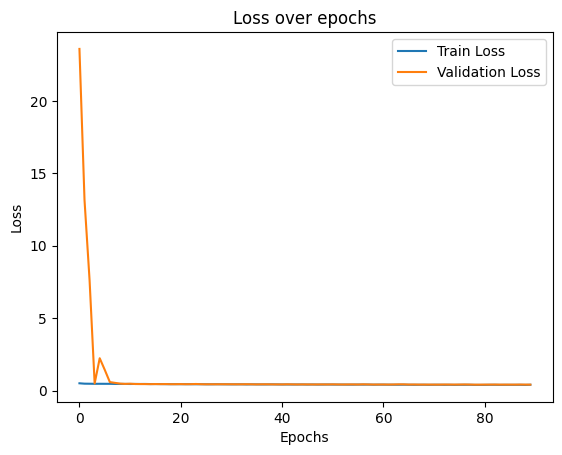

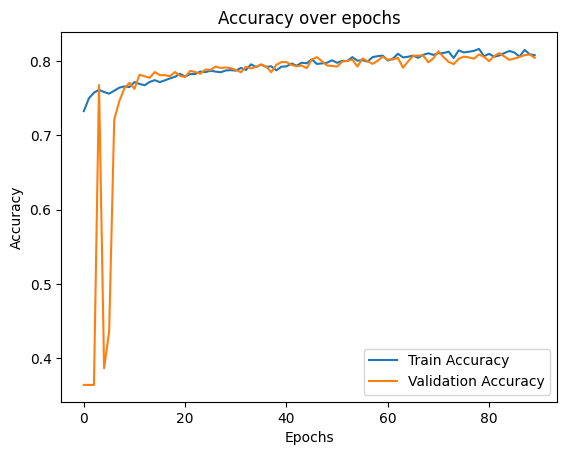

In [38]:
import matplotlib.pyplot as plt

# Loss 曲線
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

# Accuracy 曲線
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


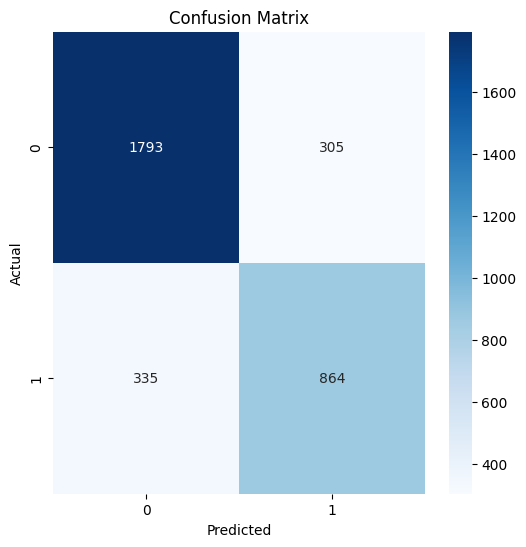

Classification Report:

              precision    recall  f1-score   support

           0     0.8426    0.8546    0.8486      2098
           1     0.7391    0.7206    0.7297      1199

    accuracy                         0.8059      3297
   macro avg     0.7908    0.7876    0.7891      3297
weighted avg     0.8049    0.8059    0.8053      3297



In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 預測結果
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype(int)  # 轉換為二分類結果

# 計算混淆矩陣
cm_a = confusion_matrix(y_test, y_pred_class)

# 繪製混淆矩陣
plt.figure(figsize=(6, 6))
sns.heatmap(cm_a, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_class, digits=4))